In [1]:
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, precision_score
from sklearn.model_selection import train_test_split
import os
import dataframe_image as dfi
import matplotlib.pyplot as plt



In [2]:
current = os.getcwd()
root = os.path.dirname(current)
path = 'data'
filename = 'cleaned_data_train.csv'

file = os.path.join(root,path,filename)
file

'/Users/cynthiaxu/Documents/MIDS/05_2024 Summer/210 Capstone/210-capstone-clinicaltrials/data/cleaned_data_train.csv'

In [3]:
# Load the dataset
data = pd.read_csv(file)

# Load the trained Random Forest model
model_path = 'model_rf.pkl'
rf_model = joblib.load(model_path)

# Assuming the target column is 'target'
exclude_columns = [
    'protocolSection_identificationModule_nctId',
    'study_eq_labels', 
    'study_duration_days', 
    'primary_eq_labels', 
    'primary_study_duration_days',
    'primary_eq_bins',
    'study_eq_bins']
target = 'study_eq_labels'
X = data.drop(columns=exclude_columns)
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['feature_dropped', 'accuracy', 'precision', 'mean_squared_error', 'mean_absolute_error'])

# Get the list of features
features = X.columns.tolist()

for feature in features:
    # Drop the feature
    X_train_dropped = X_train.drop(columns=[feature])
    X_test_dropped = X_test.drop(columns=[feature])

    # Retrain the model
    rf_model.fit(X_train_dropped, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_dropped)
    # y_pred_proba = rf_model.predict_proba(X_test_dropped)[:, 1]

    # Calculate performance metrics
    # accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    row = {
        'feature_dropped': feature,
        'accuracy': acc,
        'precision': pre,
        'mean_squared_error': mse,
        'mean_absolute_error': mae
    }
    # df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Store the results
    results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)

# results


/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_24790/1313447027.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([row])], ignore_index=True)


In [5]:
results = results.sort_values(by='mean_absolute_error', ascending=False)
styled_df = results.style.background_gradient(cmap='Greens') \
                 .set_caption('Feature Importance')
styled_df


,feature_dropped,accuracy,precision,mean_squared_error,mean_absolute_error
12,allocation,0.613402,0.598702,0.556701,0.443299
15,healthy_vol,0.618557,0.600143,0.551546,0.438144
34,phase_PHASE2_PHASE3,0.613402,0.591947,0.525773,0.432990
20,procedure_intervention,0.623711,0.608523,0.546392,0.432990
0,number_of_conditions,0.628866,0.617085,0.541237,0.427835
27,dor_outcome_measure,0.623711,0.604460,0.530928,0.427835
30,secondary_max_days,0.639175,0.625753,0.546392,0.422680
17,diagnostic_purpose,0.644330,0.635467,0.556701,0.422680
18,prevention_purpose,0.639175,0.626800,0.546392,0.422680
35,phase_PHASE3,0.639175,0.628593,0.546392,0.422680


In [6]:
iter = len(results)//3
iter

12

In [7]:
df = results.copy()

results2 = pd.DataFrame(columns=['feature_dropped', 'accuracy', 'precision', 'mean_squared_error', 'mean_absolute_error'])


for i in range(iter):
    df = df.sort_values(by='mean_absolute_error')
    # Get the top 3 features with the lowest MAE
    features_to_drop = df.head(3)['feature_dropped'].tolist()
    # Update the df
    df = df[~df['feature_dropped'].isin(features_to_drop)]

    # print(features_to_drop)

    # display(df)
    
    # Append the dropped features to the list
    # Drop the feature
    X_train_dropped = X_train.drop(columns=features_to_drop)
    X_test_dropped = X_test.drop(columns=features_to_drop)

    # Retrain the model
    rf_model.fit(X_train_dropped, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_dropped)
    # y_pred_proba = rf_model.predict_proba(X_test_dropped)[:, 1]

    # Calculate performance metrics
    # accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    row = {
        'feature_dropped': [features_to_drop],
        'accuracy': acc,
        'precision': pre,
        'mean_squared_error': mse,
        'mean_absolute_error': mae
    }
    # df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Store the results
    results2 = pd.concat([results2, pd.DataFrame([row])], ignore_index=True)
# results2

/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_24790/4204564789.py:47: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results2 = pd.concat([results2, pd.DataFrame([row])], ignore_index=True)


In [8]:
results2 = results2.sort_values(by='mean_absolute_error', ascending=False)
styled_df = results2.style.background_gradient(cmap='Greens') \
                 .set_caption('Feature Importance')
styled_df

,feature_dropped,accuracy,precision,mean_squared_error,mean_absolute_error
7,"[['masking', 'treatment_purpose', 'os_outcome_measure']]",0.623711,0.612878,0.608247,0.453608
8,"[['sponsor_type', 'phase_PHASE3', 'diagnostic_purpose']]",0.628866,0.610211,0.525773,0.422680
10,"[['dor_outcome_measure', 'number_of_conditions', 'procedure_intervention']]",0.628866,0.615069,0.525773,0.422680
11,"[['phase_PHASE2_PHASE3', 'healthy_vol', 'allocation']]",0.639175,0.626276,0.546392,0.422680
1,"[['enroll_count', 'biological_intervention', 'age_group']]",0.639175,0.629648,0.530928,0.417526
2,"[['min_treatment_duration', 'num_locations', 'number_of_intervention_types']]",0.628866,0.614313,0.510309,0.417526
3,"[['number_of_groups', 'drug_intervention', 'max_treatment_duration']]",0.634021,0.620464,0.520619,0.417526
4,"[['ae_outcome_measure', 'location', 'resp_party']]",0.634021,0.622054,0.520619,0.417526
5,"[['supportive_purpose', 'behavioral_intervention', 'intervention_model']]",0.639175,0.624976,0.515464,0.412371
9,"[['num_exclusion', 'prevention_purpose', 'secondary_max_days']]",0.644330,0.632240,0.525773,0.412371


In [9]:
df = results.copy()

results3 = pd.DataFrame(columns=['feature_dropped', 'accuracy', 'precision', 'mean_squared_error', 'mean_absolute_error'])

features_dropped = []

for i in range(len(df)-1):
    df = df.sort_values(by='mean_absolute_error')
    # Get the next feature to drop
    next_feature_to_drop = df.iloc[0]['feature_dropped']
    # print(next_feature_to_drop)
    # Add the new feature to the list of features to drop
    features_dropped.append(next_feature_to_drop)
    # Update the df
    df = df[~df['feature_dropped'].isin(features_dropped)]

    # print(features_dropped)

    # Drop the feature
    X_train_dropped = X_train.drop(columns=features_dropped)
    X_test_dropped = X_test.drop(columns=features_dropped)

    # Retrain the model
    rf_model.fit(X_train_dropped, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test_dropped)
    # y_pred_proba = rf_model.predict_proba(X_test_dropped)[:, 1]

    # Calculate performance metrics
    # accuracy = accuracy_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    pre = precision_score(y_test, y_pred, average='weighted')
    mae = mean_absolute_error(y_test, y_pred)
    # roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

    row = {
        'feature_dropped': features_dropped.copy(),
        'accuracy': acc,
        'precision': pre,
        'mean_squared_error': mse,
        'mean_absolute_error': mae
    }
    # df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # Store the results
    results3 = pd.concat([results3, pd.DataFrame([row])], ignore_index=True)
# results3

/var/folders/t7/9qpt6ghx7x132zp3932q2fb80000gn/T/ipykernel_24790/3764324589.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results3 = pd.concat([results3, pd.DataFrame([row])], ignore_index=True)
/Users/cynthiaxu/Documents/MIDS/05_2024 Summer/210 Capstone/210-capstone-clinicaltrials/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/cynthiaxu/Documents/MIDS/05_2024 Summer/210 Capstone/210-capstone-clinicaltrials/.venv/lib/python3.12/site-packages/sklearn/metrics/_classifi

In [10]:
# # results3 = results3.sort_values(by='mean_absolute_error', ascending=False)
# styled_df = results3.style.background_gradient(cmap='Greens') \
#                  .set_caption('Feature Importance')
# styled_df

In [11]:
results3["num_features_dropped"] = results3['feature_dropped'].apply(lambda x: len(x))

In [12]:
styled_df = results3.style.background_gradient(cmap='Greens') \
                 .set_caption('Feature Importance')
styled_df

,feature_dropped,accuracy,precision,mean_squared_error,mean_absolute_error,num_features_dropped
0,['survival_5yr_relative'],0.659794,0.649711,0.479381,0.386598,1
1,"['survival_5yr_relative', 'num_inclusion']",0.670103,0.663585,0.484536,0.381443,2
2,"['survival_5yr_relative', 'num_inclusion', 'has_dmc']",0.649485,0.638870,0.520619,0.407216,3
3,"['survival_5yr_relative', 'num_inclusion', 'has_dmc', 'enroll_count']",0.644330,0.636719,0.510309,0.407216,4
4,"['survival_5yr_relative', 'num_inclusion', 'has_dmc', 'enroll_count', 'biological_intervention']",0.675258,0.668954,0.479381,0.376289,5
5,"['survival_5yr_relative', 'num_inclusion', 'has_dmc', 'enroll_count', 'biological_intervention', 'age_group']",0.664948,0.658210,0.505155,0.391753,6
6,"['survival_5yr_relative', 'num_inclusion', 'has_dmc', 'enroll_count', 'biological_intervention', 'age_group', 'min_treatment_duration']",0.644330,0.634695,0.494845,0.402062,7
7,"['survival_5yr_relative', 'num_inclusion', 'has_dmc', 'enroll_count', 'biological_intervention', 'age_group', 'min_treatment_duration', 'num_locations']",0.649485,0.641121,0.489691,0.396907,8
8,"['survival_5yr_relative', 'num_inclusion', 'has_dmc', 'enroll_count', 'biological_intervention', 'age_group', 'min_treatment_duration', 'num_locations', 'number_of_intervention_types']",0.649485,0.640862,0.505155,0.402062,9
9,"['survival_5yr_relative', 'num_inclusion', 'has_dmc', 'enroll_count', 'biological_intervention', 'age_group', 'min_treatment_duration', 'num_locations', 'number_of_intervention_types', 'number_of_groups']",0.664948,0.658299,0.505155,0.391753,10


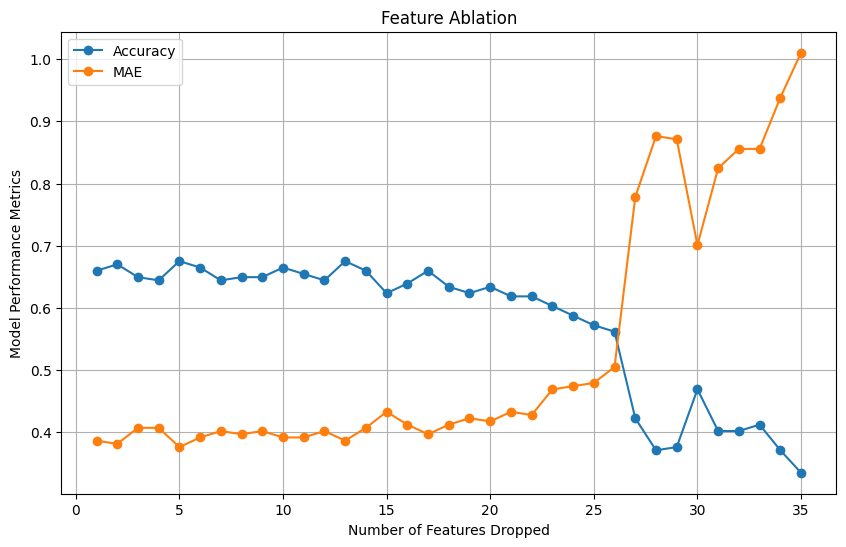

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(results3["num_features_dropped"], results3['accuracy'], marker='o', linestyle='-', label='Accuracy')
plt.plot(results3["num_features_dropped"], results3['mean_absolute_error'], marker='o', linestyle='-', label='MAE')
plt.title('Feature Ablation')
plt.xlabel('Number of Features Dropped')
plt.ylabel('Model Performance Metrics')
plt.legend()  # Show legend
plt.grid(True)
plt.show()

In [19]:
drop_features = results3.loc[results3['mean_absolute_error'].idxmin(), 'feature_dropped']
drop_features

['survival_5yr_relative',
 'num_inclusion',
 'has_dmc',
 'enroll_count',
 'biological_intervention']

In [15]:
X_train_dropped = X_train.drop(columns=drop_features)
X_test_dropped = X_test.drop(columns=drop_features)

# Retrain the model
rf_model.fit(X_train_dropped, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_dropped)
# y_pred_proba = rf_model.predict_proba(X_test_dropped)[:, 1]

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='weighted')
mae = mean_absolute_error(y_test, y_pred)

row = {
    # 'feature_dropped': features_dropped.copy(),
    'accuracy': acc,
    'precision': pre,
    'mean_squared_error': mse,
    'mean_absolute_error': mae
}

In [16]:
row

{'accuracy': 0.6597938144329897,
 'precision': np.float64(0.6525068883316306),
 'mean_squared_error': np.float64(0.5257731958762887),
 'mean_absolute_error': np.float64(0.4020618556701031)}

In [17]:
# current = os.getcwd()
# parent = os.path.dirname(current)

# save_path = os.path.join(parent, 'figures', 'feature_ablation.png')
# save_path

In [18]:
# dfi.export(styled_df, save_path)